In [264]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from keras_vggface.vggface import VGGFace

from utils.DataLoader import load_data
from models.SiameseNet import SiameseModel, build_network
from models.Attention import CBAM

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, display
import matplotlib.cm as cm

import cv2 as cv

In [2]:
def load_datasets():
    train_dataset = load_data('data\\KinFaceWIITrainFolds.tfrecords')#.take(10)
    validation_dataset = load_data('data\\KinFaceWIITestFolds.tfrecords')#.take(1)
    
    return train_dataset, validation_dataset
    

In [42]:
rgb_codes = [
        [0, 0, 0], [0, 153, 255], [102, 255, 153], [0, 204, 153],
        [255, 255, 102], [255, 255, 204], [255, 153, 0], [255, 102, 255],
        [102, 0, 51], [255, 204, 255], [255, 0, 102]
    ]

In [8]:
train_dataset, validation_dataset = load_datasets()

In [9]:
for data in train_dataset.take(1):
    anchor = data['anchor']
    pos = data['pos']
    neg = data['neg']

In [680]:
model = keras.models.load_model('Segment//model.h5')

In [681]:
inputs = neg / 255.
masks = model.predict(inputs)

In [682]:
face_mask = tf.argmax(masks, -1) != 0
face_mask = tf.expand_dims(face_mask, 3)
face_mask = tf.cast(face_mask, tf.float32)
face_mask.shape

TensorShape([128, 64, 64, 1])

In [683]:
faces = face_mask * neg

In [684]:
def grayscale_to_rgb(mask, rgb_codes):
    h, w = mask.shape[0], mask.shape[1]
    mask = mask.astype(np.int32)
    output = []

    for i, pixel in enumerate(mask.flatten()):
        output.append(rgb_codes[pixel])

    output = np.reshape(output, (h, w, 3))
    return output

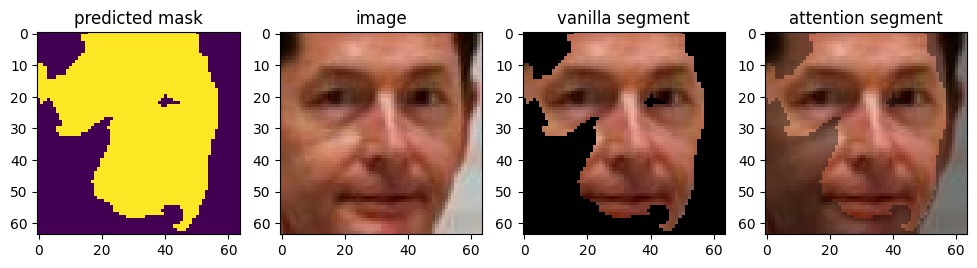

In [686]:
fig, axs = plt.subplots(1, 4, figsize=(12, 5))

idx = 0
# color_mask = grayscale_to_rgb(face_mask[idx].numpy(), rgb_codes)

attention_alpha = .4

axs[0].imshow(face_mask[idx])
axs[1].imshow(neg[idx].numpy().astype('int32'))
axs[2].imshow((faces[idx].numpy().astype('int32')))
axs[3].imshow((((faces[idx].numpy() * attention_alpha + neg[idx].numpy() * (1 - attention_alpha))).astype('int32')))

axs[0].title.set_text('predicted mask')
axs[1].title.set_text('image')
axs[2].title.set_text('vanilla segment')
axs[3].title.set_text('attention segment')

plt.show()

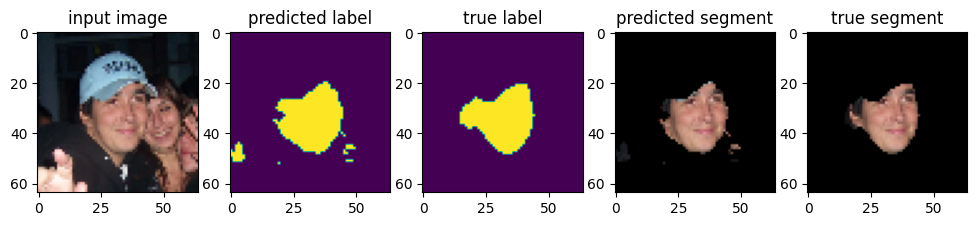

accuracy: 94.26 %


In [687]:
# img_nums = ['15731106_3', '13008107_0', '1134327_0', '1420663_0', '9698074_11', '10434549_5']
img_nums = ['2569520_1', '3013103_0', '4714621_3', '6374783_0', '7463933_1', '11985868_0', '16152627_1', '16301335_0']
img_name = img_nums[7]
section = 'test'

img = f'Segment\\Face_segmentation\\Human-Face-Segmentation-in-TensorFlow\\LaPa\\{section}\\images\\{img_name}.jpg'
label = f'Segment\\Face_segmentation\\Human-Face-Segmentation-in-TensorFlow\\LaPa\\{section}\\labels\\{img_name}.png'
img = tf.io.decode_jpeg(open(img, 'rb').read())
label = tf.io.decode_png(open(label, 'rb').read())

img = tf.image.resize(img, (64, 64))
label = tf.image.resize(label, (64, 64))

label = tf.cast(label, tf.int32)

input_img = img / 255.
input_img = tf.expand_dims(img, axis=0)
mask = model.predict(input_img)
mask = tf.argmax(mask, -1) 
mask = mask.numpy().squeeze()
mask = np.expand_dims(mask, axis=-1)

fig, axs = plt.subplots(1, 5, figsize=(12, 5))

axs[0].imshow(img.numpy().astype('int32'))
axs[1].imshow(mask.astype('int32'))
axs[2].imshow(label.numpy() != 0)
axs[3].imshow(((mask != 0) * img.numpy()).astype('int32'))
axs[4].imshow(((label.numpy() != 0) * img.numpy()).astype('int32'))

axs[0].title.set_text('input image')
axs[1].title.set_text('predicted label')
axs[2].title.set_text('true label')
axs[3].title.set_text('predicted segment')
axs[4].title.set_text('true segment')


plt.show()

print(f'accuracy: {np.sum(mask == label.numpy().astype("int32")) / (64 * 64) * 100 :.2f} %')